<a href="https://colab.research.google.com/github/flosch9/deep_learning_home_exam/blob/main/Task_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive for loading data and saving results

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Search for GPU for faster computation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 22 10:56:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |   6119MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Define Model architecture (model.py)

In [307]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg11_bn
from torchvision.models import VGG11_BN_Weights


# Define the model
class VGG11(nn.Module):
    def __init__(self, classes=16, split_images = False, mode = "sinkhorn",
                 sinkiterations = 4):
        """
        modes: "sinkhorn" or "single"
        in mode "sinkhorn" the permutation will be represented by an
        permutation matrix (which is flattened out) and the sigmoid function
        is replaced by a sinkhorn iteration. The output in this case has size 16

        in mode "single" each possible permutation is assigned to one class.
        the output has size 24 (which is eqaul to the 24 = 4! possible
        permutations)

        split: True/False
        determines if the initial image is split in four quarters
        (the shuffeld tiles) and each quater goes separatly trough
        the convolutional part of the net before the outputs will be
        concatenated for the classifier

        sinkiterations: int
        gives the number of iterations for the sinkhorn-iteration
        """
        super(VGG11, self).__init__()

        self.mode = mode
        self.split = split_images
        self.sinkiterations = sinkiterations


        if mode == "single":
            self.classes = 24
        elif mode == "sinkhorn":
            self.classes = 16

        # set size of output from convolutional part
        if self.split:
            self.vgg_output = 2048
            #4000 if whole vgg11 is used and not only the feature-part
        else:
            self.vgg_output = 4608
            #1000 if whole vgg11 is used and not only the feature-part

        # get the first (convolutional) part with batch normalization of a vgg11
        self.vggnet = vgg11_bn(weights= None ).features
        #self.vggnet = vgg11_bn(weights='IMAGENET1K_V1').features
        # should not use weights, just for experementing

        # second part of network with own defined classifier
        self.extraclassifier = nn.Sequential(
            nn.Dropout(p=0.2),

            nn.Linear(self.vgg_output, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(256, self.classes)
        )

        # last part of output layer, defined seperatly for switching between
        # "sinkhorn" and "simple"
        self.sigmoid = nn.Sigmoid()

    # implementation of sinkhorn iteration (for normalizing the output)
    def sinkhornIteration(self, x):

        x = x.view(-1,4,4)

        for i in range(5):
            x = x/x.sum(dim = 1, keepdim = True)
            x = x/x.sum(dim = 2, keepdim = True)

        x = x.view(-1,16)

        return(x)

    def forward(self, x):

        # only when image split
        if self.split:

            q1= x[:,:,0:48,0:48]
            q2= x[:,:,0:48,48:96]
            q3= x[:,:,48:96,0:48]
            q4= x[:,:,48:96,48:96]

            x1= self.vggnet(q1)
            x2= self.vggnet(q2)
            x3= self.vggnet(q3)
            x4= self.vggnet(q4)

            x = torch.cat((x1,x2,x3,x4),dim = 1)

        else:
            x = self.vggnet(x)

        x = x.view(x.size(0), -1)
        x = self.extraclassifier(x)

        if self.mode == "sinkhorn":
            x = self.sinkhornIteration(x)
        else:
            x = self.sigmoid(x)

        return(x)

# Define functions for training, testing, vizualisation and data handling (funcs.py)

In [311]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize
from torchvision.utils import make_grid

###############################################################################
# functions for data handling and label representation
###############################################################################

def deshuffler(img_s, order):
    """
    Takes a shuffled image and reshuffles it according to a given order.
    img_s: A shuffled image of size (3x96x96).
    order: Order of patches from shuffled image in dehuffled image of size (4, ).
    """

    img_ns = np.zeros_like(img_s)

    num_tiles = 2
    tile_size = 96 // num_tiles

    starting_points = []
    for i in range(num_tiles):
        for j in range(num_tiles):
            starting_points.append((i*tile_size, j*tile_size))

    for i in range(num_tiles**2):

        x_idx = starting_points[i][0]
        y_idx = starting_points[i][1]

        x_idx_p = starting_points[order[i]][0]
        y_idx_p = starting_points[order[i]][1]

        img_ns[:, x_idx_p:x_idx_p+tile_size, y_idx_p:y_idx_p+tile_size] = img_s[:, x_idx:x_idx+tile_size, y_idx:y_idx+tile_size]

    return img_ns


def load_data(path):
    """
    Loads the shuffled data from a numpy array.
    Returns 4 numpy arrays in the following order:
    training images, training labels / order, test images, and test labels/order.
    path: path to numpy array
    """
    data = np.load(path)

    x_tr = data['a']     # Loads the training images.
    y_tr = data['b']     # Loads the labels/order of the training images.
    x_te = data['c']     # Loads the test images.
    y_te = data['d']     # Loads the labels/order of the test images.

    return x_tr, y_tr, x_te, y_te


def smallerDataset(dataset, size):
    """
    Creates a smaller (sub)dataset of the original dataset with given size.
    Should only be used for debugging.
    """

    smaller_dataset = []

    for i in range(size):
        smaller_dataset.append(dataset[i])

    return(smaller_dataset)


def getPermutationMatrix(labels, device):
    """
    Creates a permutation matrix (size 4x4) (flattened out to a vector) for a
    given permutation. For example the permutation [1,0,3,2] creates the matrix
    [0, 1, 0, 0]
    [1, 0, 0, 0]
    [0, 0, 0, 1]
    [0, 0, 1, 0]
    which is [0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0] as vector.
    Is used for encoding the original labels when the mode "sinkhorn" is choosen
    """
    size = len(labels)

    perm_tensors = []

    for label in labels:
        n = label.size(0)

        perm_matrix = torch.zeros((n, n))

        for i, j in enumerate(label):
            perm_matrix[int(i), int(j.item())] = 1

        perm_tensors.append(perm_matrix.flatten())

        perm_vector = torch.stack(perm_tensors, dim=0)

    # returm permutation to same device whwe model runs on
    return(perm_vector.to(device))


def getOrigLabel(vectors):
    """
    Recovers original labels in form of [1,0,3,2] (for example) for a given
    permutation matrix (size 4x4) (which is flattened out to a vector).
    Is used for evaluation of the model when model was trained in mode "sinkhorn"
    """

    perm_labels = []

    for vector in vectors:
        n = int(vector.shape[0] ** 0.5)
        matrix = torch.tensor(vector).view(n, n)
        permutation = torch.argmax(matrix, dim=1)
        perm_label = permutation.tolist()
        perm_labels.append(perm_label)

    perm_labels = torch.tensor(perm_labels) #dtype=torch.long)

    return(perm_labels)


def getPseudoLabel(label_array, device):
    """
    Creates a Pseudolabel of size 24.
    Each possible permutation (labels) is assigned to one class,
    overal 24 classes.
    Is used in mode "single".
    """
    pseudolabel = []

    device = label_array.device

    # define pseudolabels, 24 possibilities of permutation
    labels = torch.tensor([[0,1,2,3],
                            [0,1,3,2],
                            [0,2,1,3],
                            [0,2,3,1],
                            [0,3,1,2],
                            [0,3,2,1],
                            [1,0,2,3],
                            [1,0,3,2],
                            [1,2,0,3],
                            [1,2,3,0],
                            [1,3,0,2],
                            [1,3,2,0],
                            [2,1,0,3],
                            [2,1,3,0],
                            [2,0,1,3],
                            [2,0,3,1],
                            [2,3,1,0],
                            [2,3,0,1],
                            [3,1,2,0],
                            [3,1,0,2],
                            [3,2,1,0],
                            [3,2,0,1],
                            [3,0,1,2],
                            [3,0,2,1]], device=device)

    for label in label_array:
        pseudolabel.append([1 if torch.equal(label, labels[i]) else 0 for i in range(len(labels))])

    pseudolabel = torch.tensor(pseudolabel, device=device).float()

    return(pseudolabel)


def getRealLabel(pseudolabel_array):
    """
    Recovers original label (size 4, for example [3,0,1,2])
    from a given pseudolabel of size 24.
    Is used in mode "single".
    """

    reallabel = []

    device = pseudolabel_array.device

    labels = torch.tensor([[0,1,2,3],
                            [0,1,3,2],
                            [0,2,1,3],
                            [0,2,3,1],
                            [0,3,1,2],
                            [0,3,2,1],
                            [1,0,2,3],
                            [1,0,3,2],
                            [1,2,0,3],
                            [1,2,3,0],
                            [1,3,0,2],
                            [1,3,2,0],
                            [2,1,0,3],
                            [2,1,3,0],
                            [2,0,1,3],
                            [2,0,3,1],
                            [2,3,1,0],
                            [2,3,0,1],
                            [3,1,2,0],
                            [3,1,0,2],
                            [3,2,1,0],
                            [3,2,0,1],
                            [3,0,1,2],
                            [3,0,2,1]], device=device)

    for label in pseudolabel_array:

        reallabel.append(labels[int(label.argmax().item())])

    reallabels = torch.stack(reallabel)

    return(reallabels)


###############################################################################
# finctions for training and testing
###############################################################################

def testModel(model, lossFunction, test_dataload, BATCHSIZE):
  """
  Function for calculating testing (or validation) loss for monitoring training
  process. Calculates the loss of the model based on the test-data and returns
  it. Runs with batches of size BATCHZISE trough whole test dataset
  (once, like one epoch) and saves loss for each batch in file. Returns overall
  loss for epoch for monitoring.
  """

  # initializing running loss and number of batches
  test_loss = 0
  batch_number = 0

  # set model to eval-mode, turns off DropOut an Batchnorm Layers
  model.eval()

  # unpack images and labels from test data
  test_images, test_labels = test_dataload

  for i in range(0, len(train_images), BATCHSIZE):

        # create batch
        batch_images = test_images[i:i+BATCHSIZE]
        batch_labels = test_labels[i:i+BATCHSIZE]

        # clear out gradients
        Optimizer.zero_grad()

        # forward pass, calculate output of model
        outputs = model(batch_images)

        # compute loss
        loss = lossFunction(outputs, batch_labels)

        # ad batch-loss to running loss, increase batchnumber
        test_loss += loss.item()
        batch_number += 1

        # write loss in file for potential, finer analysis later
        with open(FOLDERPATH + "testing_loss_fine.csv", 'a') as file:
            file.write("{};\t{}\n".format(i+1, loss))

  # return loss of test-run for epch
  return(test_loss/batch_number)


def trainBatch(model, lossFunction, Optimizer,
              train_dataload, test_dataload, BATCHSIZE,
              NUMBEREPOCHS, FOLDERPATH):
  """
  Function for calculating training loss. Calculates the loss of the model
  based on the train-data and returns
  it. Runs with batches of size BATCHZISE trough whole test dataset
  (once) and saves loss for each batch in file. Returns overall
  loss for epoch. Also after each batch the weights of the model are updated
  by the Optimizer
  """
  running_loss = 0
  batch_number = 0

  # set model in train mode for enabling dropout, batchnorm etc.
  model.train()

  train_images, train_labels = train_dataload

  for i in range(0, len(train_images), BATCHSIZE):

        batch_images = train_images[i:i+BATCHSIZE]
        batch_labels = train_labels[i:i+BATCHSIZE]

        # clear gradients
        Optimizer.zero_grad()
        # forward pass
        outputs = model(batch_images)

        # compute loss
        loss = lossFunction(outputs, batch_labels)

        # for better training (try to avoide overfitting) l1 regularization is
        # implemented at this point, modifies loss and adds "penalty"
        l1_lambda = 0.001
        l1_norm = sum(torch.linalg.norm(p) for p in model.parameters())

        loss = loss + l1_lambda * l1_norm

        # backpropagation
        loss.backward()

        # updating model
        Optimizer.step()

        # ad batch loss to running loss (foor whole epoch)
        running_loss += loss.item()
        batch_number += 1

        # saving loss for each batch to file
        with open(FOLDERPATH + "training_loss_fine.csv", 'a') as file:
          file.write("{};\t{}\n".format(i+1, loss))

  return(running_loss/batch_number, batch_number)


def trainModel(model, lossFunction, Optimizer,
              train_dataload, test_dataload,
              BATCHSIZE, NUMBEREPOCHS, FOLDERPATH):

  """
  Main training (and testing) function.
  """

  with open(FOLDERPATH + "training_loss_fine.csv", 'w') as file:
            file.write("Batch number; loss\n")

  with open(FOLDERPATH + "testing_loss_fine.csv", 'w') as file:
    file.write("Batch number; loss\n")

  training_loss = np.zeros(NUMBEREPOCHS)
  test_loss = np.zeros(NUMBEREPOCHS)

  for epoch in range(NUMBEREPOCHS):

    # train every batch
    training_loss[epoch], batch_number = trainBatch(model, lossFunction,
                                           Optimizer, train_dataload,
                                           test_dataload, BATCHSIZE,
                                           NUMBEREPOCHS, FOLDERPATH)

    # test in each epoch
    test_loss[epoch] = testModel(model, lossFunction, test_dataload,
                                    BATCHSIZE)

    # reporting
    print("\nEpoch [{}/{}]".format(epoch+1,NUMBEREPOCHS))
    print("{} updates in this epoch.".format(batch_number))
    print("Trainingloss: {}".format(training_loss[epoch]))
    print("Testingloss: {}".format(test_loss[epoch]))

  # save model after training
  torch.save(model.state_dict(), FOLDERPATH + "model_v" + VERSION)
  print("\nTrained model parameters saved in {}.".format(FOLDERPATH))

  return(training_loss, test_loss)


def plotLosses(training_loss, test_loss, FOLDERPATH):
  """
  Plotting training and testing loss for each epoch
  """

  x = np.linspace(1,len(training_loss), num=len(training_loss))

  plt.plot(x, training_loss, '.', label = "training")
  plt.plot(x, test_loss, '.', label = "testing")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc = "best")
  plt.savefig(FOLDERPATH + "losses_during_training.png")

  return()

###############################################################################
# evaluation
###############################################################################

def getAccuracy(prediction, labels):
    """
    Calculating accuracy for images deshuffeld and quarters (tiles) assigned
    right. Returns absolut number of how many images/ tiles where right
    """

    correct_images = 0
    correct_quarters = 0

    for i in range(prediction.shape[0]):
        if (prediction[i] == labels[i]).all():
            correct_images += 1
        for j in range(4):
            if prediction[i][j] == labels[i][j]:
                correct_quarters +=1

    return(correct_images, correct_quarters)



def visualizeOutputs(test_images, test_labels,
                     output, FOLDERPATH):

  """
  Vizualise output of model. Choose random
  """

  deshuffeld_images = []
  predictions = []

  for image, label, out in zip(test_images, test_labels, output):
    deshuffeld_image = deshuffler(image.cpu(), label.int().cpu())
    predicted_deshuffel = deshuffler(image.cpu(), out.int().cpu())

    deshuffeld_images.append(torch.tensor(deshuffeld_image))
    predictions.append(torch.tensor(predicted_deshuffel))

  grid_1 = ToPILImage()(make_grid(test_images,
                                  nrow = int(len(test_images)/3),
                                  normalize = True))
  grid_2 = ToPILImage()(make_grid(deshuffeld_images,
                                  nrow = int(len(deshuffeld_images)/3),
                                  normalize = True))
  grid_3 = ToPILImage()(make_grid(predictions,
                                  nrow = int(len(predictions)/3),
                                  normalize = True))

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize =(10,6))
  ax[0].imshow(grid_1)
  ax[0].set_title("Original shuffeld images")
  ax[0].axis("off")
  ax[1].imshow(grid_2)
  ax[1].set_title("Deshuffeld images based on label")
  ax[1].axis("off")
  ax[2].imshow(grid_3)
  ax[2].set_title("Deshuffeld images based on prediction")
  ax[2].axis("off")
  fig.tight_layout()
  plt.savefig(FOLDERPATH + "output_visualisation.png")

  return()


def evaluateVGG(model, test_dataload, BATCHSIZE, MODELMODE, FOLDERPATH):

  model.eval()

  test_images, test_labels = test_dataload

  if MODELMODE == "sinkhorn":
    test_labels = getOrigLabel(test_labels)

  if MODELMODE == "single":
    test_labels = getRealLabel(test_labels)


  datasize = test_images.shape[0]

  correct_images = 0
  correct_quarters = 0

  step = int(datasize/ BATCHSIZE)

  stop = datasize-BATCHSIZE

  # for making plot
  i = torch.randint(0, stop, (1,)).item()

  plot_im = test_images[i:i+9]
  plot_label = test_labels[i:i+9]

  if MODELMODE == "sinkhorn":
    plot_pred = getOrigLabel(model(plot_im))

  if MODELMODE == "single":
    plot_pred = getRealLabel(model(plot_im))

  visualizeOutputs(plot_im, plot_label, plot_pred, FOLDERPATH)

  with torch.no_grad():

    for i in range(0, stop, BATCHSIZE):

        batch_images = test_images[i:i+BATCHSIZE]
        batch_labels = test_labels[i:i+BATCHSIZE]

        outputs = model(batch_images)

        if MODELMODE == "sinkhorn":
          predicted = getOrigLabel(outputs)

        if MODELMODE == "single":
          predicted = getRealLabel(outputs)

        correct_images += getAccuracy(predicted, batch_labels)[0]
        correct_quarters += getAccuracy(predicted, batch_labels)[1]

  with open(FOLDERPATH + "evaluation.csv", 'w') as file:
    file.write("Accuracy on deshuffeld images (%); Accuracy on right quaters (%)\n")
    file.write("{}; {}".format(100*correct_images/datasize,
                               100*correct_quarters/(4*datasize)))

  print("Accuracy on images during test: {}%".format(100*correct_images/datasize))
  print("Accuracy on quaters during test: {}%".format(100*correct_quarters/(4*datasize)))


  return()


  def guidedBackprop(model, input_images, FOLDERPATH):

    def relu_hook_function(module, grad_in, grad_out):
      if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

    for i, module in enumerate(model.modules()):
      if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

    # select images for guided backprop
    datasize = test_images.shape[0]
    stop = datasize-9

    # for making plot
    i = torch.randint(0, stop, (1,)).item()

    plot_images = test_images[i:i+9]

    plot_gradients = []

    for image in plot_images:

      image = image.to(device).view(1,3, image.shape[1], image.shape[2])
      image.requires_grad = True


      model.eval()
      output = model(image)

      target_class = torch.argmax(output)

      # Zero gradients
      model.zero_grad()

      # Backward pass
      output[0, target_class].backward()

      #gradient = image.grad.clone()
      gradient = image.grad

      #remove negative values and normalize
      gradient = gradient.squeeze().cpu()
      #gradient = torch.maximum(gradient.cpu(), torch.zeros(gradient.shape))
      gradient /= gradient.max()

      plot_gradients.append(torch.tensor(gradient))


    grid_1 = ToPILImage()(make_grid(plot_images,
                                  nrow = int(len(plot_images)/3),
                                  normalize = True))
    grid_2 = ToPILImage()(make_grid(plot_gradients,
                                  nrow = int(len(plot_gradients)/3),
                                  normalize = True))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize =(10,6))
    ax[0].imshow(grid_1)
    ax[0].set_title("Original images")
    ax[0].axis("off")
    ax[1].imshow(grid_2)
    ax[1].set_title("Gradients from guided backpropagation")
    ax[1].axis("off")
    fig.tight_layout()
    plt.savefig(FOLDERPATH + "guided_backprop_visualisation.png")

    return()


# Train and evaluate model (main.py)


------------------------------------------------------------------


Found GPU!


WARNING
Folder allready exist.
Delte this folder? (y/n)
y
File with trainingparameters of model saved in 
 /content/drive/MyDrive/Deep_learning_home_exam/data/problem3/VGG11_v22/

------------------------------------------------------------------

Dataset loaded.

------------------------------------------------------------------

Starting training.


Epoch [1/100]
157 updates in this epoch.
Trainingloss: 0.5821269378540622
Testingloss: 0.19108543843980047

Epoch [2/100]
157 updates in this epoch.
Trainingloss: 0.5214215201936709
Testingloss: 0.1913636821280619

Epoch [3/100]
157 updates in this epoch.
Trainingloss: 0.4832119366545586
Testingloss: 0.18169069973526486

Epoch [4/100]
157 updates in this epoch.
Trainingloss: 0.43290064289311697
Testingloss: 0.16348024861068483

Epoch [5/100]
157 updates in this epoch.
Trainingloss: 0.38813687357932897
Testingloss: 0.14329787870501257

Epoch [6/100]
157 upda

<ipython-input-251-69f83a5768f6>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_gradients.append(torch.tensor(gradient))


Finished training.

------------------------------------------------------------------



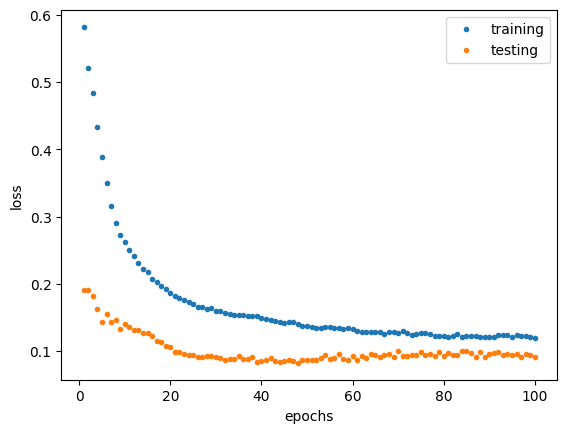

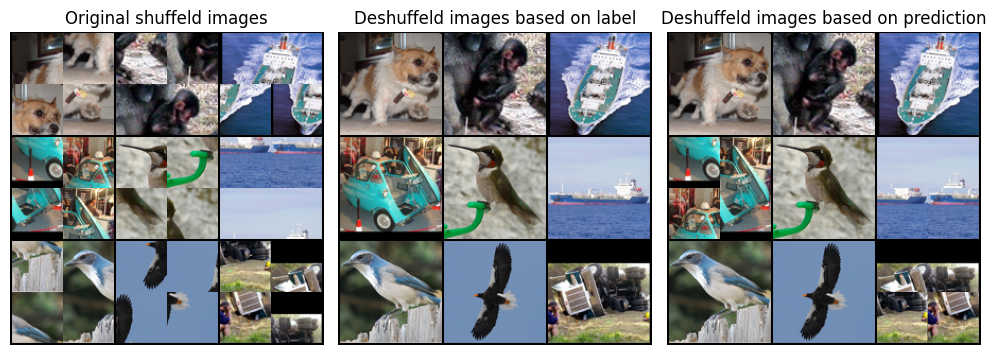

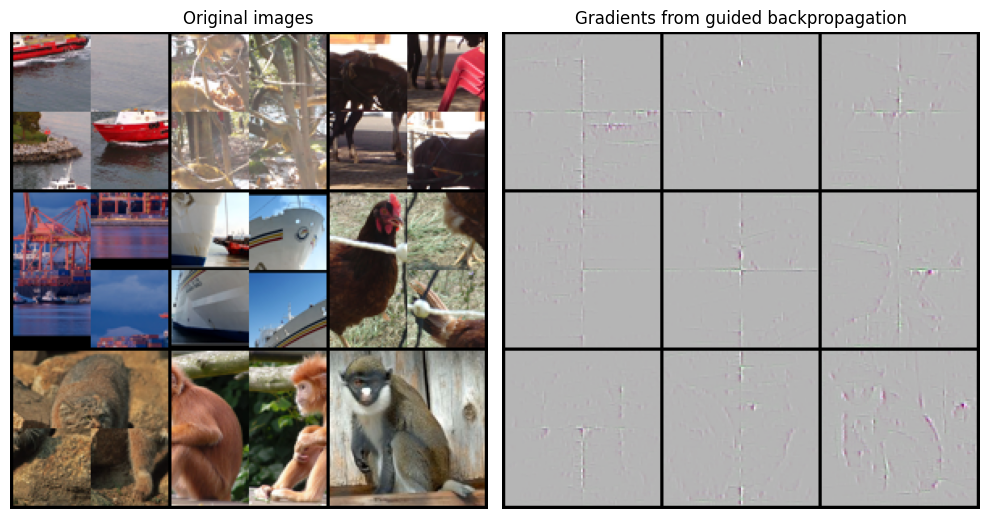

In [308]:
import os, shutil
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize

#from torchvision.models import vgg16, VGG16_Weights

#from model import VGG11
#from funcs import *

#from test import show_output, test_model, show_uncertainity_map

###############################################################################
# general Parameters for training (make adjustments here)
###############################################################################
# Path for notebook
ROOTPATH = "/content/drive/MyDrive/Deep_learning_home_exam/data/problem3/"

# Path for local
#ROOTPATH = "home_exam\data\problem2\\"

# for saving model with trained parameters
VERSION = "22"

MODE = "train" # "train" or "evaluate"

# parameters for training (only for mode "train")
NUMBEREPOCHS = 100
BATCHSIZE = 16
LEARNINGRATE = 0.001

# resize dataset to see faster runtrough
SMALLDATASET = False
smaller_train_dataset_size = 250
smaller_test_dataset_size = 250


MODELMODE = "single" #"single" or "sinkhorn"
SPLITIMAGE = False


model = VGG11(split_images = SPLITIMAGE, mode = MODELMODE)

lossFunction = nn.BCELoss() #nn.MSELoss() no cross entropy loss

Optimizer = optim.Adam(model.parameters(),lr = LEARNINGRATE)#, weight_decay = 0.0001) #optim.SGD()

# maybe only train last part
# turn grad of pre layers off

#for name, param in model.named_parameters():
#    print(name, param.requires_grad)



print("\n------------------------------------------------------------------\n")

###############################################################################
# directory for output files for model version / loading model
###############################################################################

foldername = "VGG11_v" + VERSION + "/"
FOLDERPATH = os.path.join(ROOTPATH, foldername)

###############################################################################
# adjust size of datasets
###############################################################################

if BATCHSIZE >= smaller_train_dataset_size:
  smaller_train_dataset_size = BATCHSIZE + 1

if BATCHSIZE >= smaller_test_dataset_size:
  smaller_test_dataset_size = BATCHSIZE + 1

###############################################################################
# try to train on GPU
###############################################################################

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print("\nFound GPU!\n")

model.to(device)

###############################################################################
# save parameters of model
###############################################################################

if MODE == "train":

  if os.path.exists(FOLDERPATH):

    print("\nWARNING\nFolder allready exist.")
    delete = input("Delte this folder? (y/n)\n")

    if delete == "y":
      shutil.rmtree(FOLDERPATH)
      os.mkdir(FOLDERPATH)

    else:
      sys.exit("Change name or delete folder.")

  else:
    os.mkdir(FOLDERPATH)

  parameters = {"Modelversion" : VERSION,
                "Batchsize" : BATCHSIZE,
                "Learningrate" : LEARNINGRATE,
                "Number Epochs" : NUMBEREPOCHS,
                "Mode of model" : MODELMODE,
                "Splitted Image": SPLITIMAGE,
                "Optimizer" : str(Optimizer),
                "Model architectur" : str(model)}

  with open(FOLDERPATH + "training_parameters.json", 'w') as file:
    json.dump(parameters, file)

  print("File with trainingparameters of model saved in \n {}".format(FOLDERPATH))
  print("\n------------------------------------------------------------------\n")

###############################################################################
# reload model for evaluation
###############################################################################

if MODE == "evaluate":

  if not os.path.exists(os.path.join(FOLDERPATH + "training_parameters.json")):
    sys.exit("File with parameters doesnt exists")

  with open(FOLDERPATH + "training_parameters.json", newline='') as file:
    parameters = json.load(file)

  VERSION = parameters["Modelversion"]
  BATCHSIZE = parameters["Batchsize"]
  LEARNINGRATE = parameters["Learningrate"]
  NUMBEREPOCHS = parameters["Number Epochs"]
  MODELMODE = parameters["Mode of model"]
  SPLITIMAGE = parameters["Splitted Image"]

  model = VGG11(split_images = SPLITIMAGE, mode = MODELMODE)
  model.load_state_dict(torch.load(FOLDERPATH + "model_v" + VERSION),
                                   map_location=device)

  print("Loaded model version {} for evaluation".format(VERSION))
  print("\n------------------------------------------------------------------\n")

###############################################################################
# load dataset for training
###############################################################################

train_images, train_labels, test_images, test_labels  = load_data(ROOTPATH + "DataShuffled.npz")


# use smaller dataset for faster runntime during debugging
if SMALLDATASET:
    print("Use reduced size of dataset for faster runtime. ONLY FOR DEBUGGING!\n")

    train_labels = smallerDataset(train_labels,smaller_train_dataset_size)
    train_images = smallerDataset(train_images,smaller_train_dataset_size)
    test_labels = smallerDataset(test_labels,smaller_test_dataset_size)
    test_images = smallerDataset(test_images,smaller_test_dataset_size)

train_images = torch.tensor(train_images).float().to(device) #to device!?
train_labels = torch.tensor(train_labels).float().to(device)
test_images = torch.tensor(test_images).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

if MODELMODE == "sinkhorn":
  train_labels = getPermutationMatrix(train_labels, device)
  test_labels = getPermutationMatrix(test_labels, device)

if MODELMODE == "single":
  train_labels = getPseudoLabel(train_labels, device)
  test_labels = getPseudoLabel(test_labels, device)

train_dataload = [train_images, train_labels]
test_dataload = [test_images, test_labels]

print("Dataset loaded.")
print("\n------------------------------------------------------------------\n")

###############################################################################
# training and testing
###############################################################################

if MODE == "train":
  print("Starting training.\n")

  training_loss, test_loss = trainModel(model, lossFunction, Optimizer,
                                        train_dataload, test_dataload, BATCHSIZE,
                                        NUMBEREPOCHS, FOLDERPATH)

  plotLosses(training_loss, test_loss, FOLDERPATH)

  print("Finished training.")
  print("\n------------------------------------------------------------------\n")

###############################################################################
# evaluation
###############################################################################

print("Starting evaluation.")

evaluateVGG(model, test_dataload, BATCHSIZE, MODELMODE, FOLDERPATH)

guidedBackprop(model, test_images, FOLDERPATH)

print("\nFinished evaluation.")
print("\n------------------------------------------------------------------\n")




<ipython-input-309-9750ac4565a5>:500: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_gradients.append(torch.tensor(gradient))


()

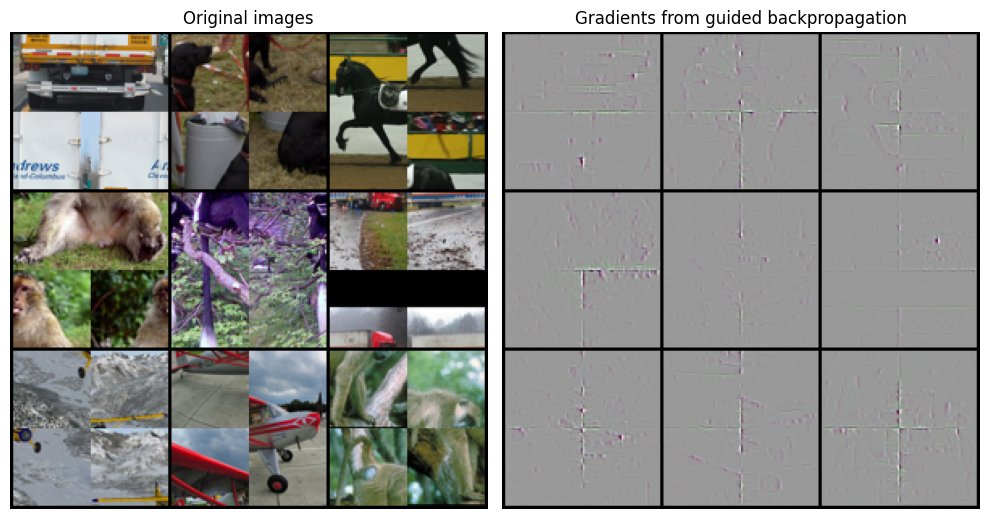

In [310]:
guidedBackprop(model, test_images, FOLDERPATH)